# Libraries

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D,Concatenate, Cropping2D, ZeroPadding2D
import tensorflow as tf
import random
import keras
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.models import load_model
from IPython.display import clear_output
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import roc_curve, auc
import matplotlib
seed = 2019
np.random.seed = seed
random.seed = seed
tf.seed = seed
path = '/home/von/Downloads/archive(1)/Dataset'


In [3]:
from IPython.display import Image

# Preprocessing

In [4]:
#image_id_list = train['image_id'].unique().tolist()
image_id_list = os.listdir(path+'/Nepceleb_sketch')

In [5]:
#image_id_list = sum(image_id_list,[])
print(len(image_id_list),image_id_list)

1626 ['001306.jpg', '000613.png', '000739.jpg', '001049.jpg', '000036.jpg', '000131.png', '001026.jpg', '000218.jpg', '000957.jpg', '001105.jpg', '000761.jpg', '000916.jpg', '000805.jpg', '001465.jpg', '000355.jpg', '001523.jpg', '000172.png', '000497.jpg', '001183.jpg', '000625.jpg', '000294.JPG', '001264.jpg', '001112.jpg', '001387.jpg', '001538.jpg', '000464.jpg', '000129.jpg', '000251.jpg', '000934.jpg', '000636.jpg', '000658.jpg', '000226.jpg', '000061.jpg', '000787.jpg', '000142.jpg', '000847.jpg', '000423.jpg', '000704.jpg', '001597.jpg', '000313.jpg', '000548.jpg', '000992.jpg', '001350.jpg', '000273.jpg', '000530.jpg', '000507.jpg', '000727.jpg', '000773.jpg', '001437.jpg', '000356.jpg', '001165.jpg', '000235.jpg', '000846.jpg', '001273.jpg', '000555.jpg', '000428.jpg', '000967.jpg', '000958.jpg', '000025.jpg', '000092.jpg', '000641.jpg', '000078.jpg', '001304.jpg', '001218.jpg', '000742.jpg', '000029.jpg', '000463.jpeg', '000984.jpg', '000554.jpg', '000605.jpg', '000807.jpg',

# Hyperparameters    
- image size
- train path
- epochs
- validation size
- Generator Declaration

In [6]:
image_size = (218,178)
train_path = '/home/von/Downloads/archive(1)/Dataset'
epochs = 50
validation_size = 16


# Utility Function

# Data Generator

In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,ids,filepath,batch_size=16,image_size=(480,640),channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
            return (len(self.ids)//self.batch_size)
                   
                     
    def __getitem__(self,index):
            indexes = range(index*self.batch_size,index*self.batch_size+self.batch_size)
            
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i,m in enumerate(X):
                l.append(m.reshape(218,178,3))
            X = np.array(l)
            l = []
            for i,m in enumerate(y):
                l.append(m.reshape(218,178,3))
            y = np.array(l)
            return X,y
            
        
        
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                #print(self.filepath+'/sketch/'+id_n+'-sz1.jpg')
                img = cv2.imread(self.filepath+'/Nepceleb_sketch/'+id_n)
                '''plt.imshow(img)
                plt.show()'''
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                
                img = img.astype(np.float32)/255.
                
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                X[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size,self.image_size[0],self.image_size[1],self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath+'/Nepceleb/'+id_n)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0],self.image_size[1]))
                '''plt.imshow(img)
                plt.show()'''
                y[i,:,:,:] = img.reshape(self.image_size[0],self.image_size[1],self.channels)
            return y
             
        

# Sample plot of data

In [8]:
# Dataset split: 80% train / 10% validation / 10% test
train_size = int(len(image_id_list) * 0.8)
val_size = int(len(image_id_list) * 0.1)
test_size = len(image_id_list) - train_size - val_size

train_gen = DataGenerator(image_id_list[:train_size],train_path,batch_size=8,image_size=(178,218),channels=3)
val_gen = DataGenerator(image_id_list[train_size:train_size+val_size],train_path,batch_size=8,image_size=(178,218),channels=3)
test_gen = DataGenerator(image_id_list[train_size+val_size:],train_path,batch_size=8,image_size=(178,218),channels=3)

In [9]:

X,y = val_gen.__getitem__(1)
val_gen.__len__()
#train_gen.__len__()

20

In [10]:
len(image_id_list)

1626

In [11]:
X.shape

(8, 218, 178, 3)

In [12]:
cv2.imwrite('file.jpg',X[1]*255.)

True

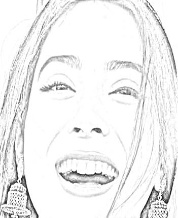

In [13]:
Image(filename='file.jpg')

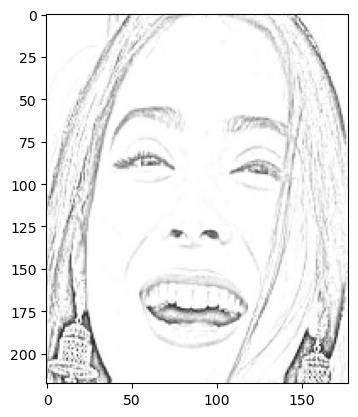

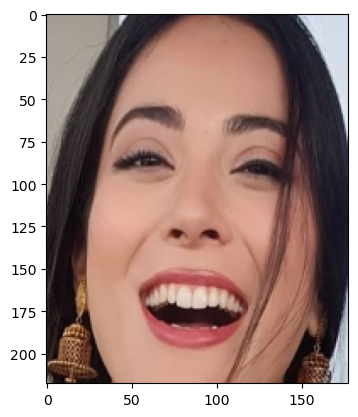

In [14]:
plt.imshow(X[1])
plt.show()
plt.imshow(y[1])
plt.show()

# Loss Function

In [15]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

# Different Convolution block

In [16]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.shape[2] - refer.shape[2])
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.shape[1] - refer.shape[1])
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)





def down_block(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(x)
    c = Conv2D(filters,kernel_size=kernel_size,padding=padding,strides=strides,activation=activation)(c)
    p = MaxPooling2D((2,2))(c)
    return c,p

def up_block(x,skip,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    us = UpSampling2D((2,2))(x)
    ch, cw = get_crop_shape(skip,us)
    us = ZeroPadding2D(padding = (ch,cw))(us)
    #ch, cw = get_crop_shape(skip,us)
    #skip = Cropping2D(cropping=(ch,cw))(skip)
    us = Concatenate()([us,skip])
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
    us = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(us)
    return us
    
def bottleneck(x,filters,kernel_size=(3,3),strides=1,padding='same',activation='relu'):
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(x)
    b = Conv2D(filters,kernel_size,padding=padding,strides=strides,activation=activation)(b)
    return b

# Unet Model

In [17]:
def Unet():
    f = [16,32,64,128,256]
    inputs = Input((image_size[0],image_size[1],3))
    
    c1,p1 = down_block(inputs,f[0])#350->175, 525->262
    c2,p2 = down_block(p1,f[1])#175->87, 262-> 131
    c3,p3 = down_block(p2,f[2])#87->43, 131 -> 65 
    c4,p4 = down_block(p3,f[3])#43->21, 65->32
    b = bottleneck(p4,f[4])#21,32
    u1 = up_block(b,c4,f[3])#
    u2 = up_block(u1,c3,f[2])#16->32
    u3 = up_block(u2,c2,f[1])#32->64
    u4 = up_block(u3,c1,f[0])#64->128
    
    outputs = Conv2D(3,(1,1),padding='same',activation='sigmoid')(u4)
    
    model = Model(inputs,outputs)
    
    return model    

# Training the Model

In [19]:
model = Unet()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[dice_loss])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 218, 178, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 218, 178, 16)         2320      ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 109, 89, 16)          0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

Epoch 1/50
162/162 [==============================] - 14s 86ms/step - loss: 0.0115 - dice_loss: 0.4069 - val_loss: 0.0237 - val_dice_loss: 0.3958
Epoch 2/50
162/162 [==============================] - 14s 86ms/step - loss: 0.0105 - dice_loss: 0.4049 - val_loss: 0.0242 - val_dice_loss: 0.3974
Epoch 3/50
162/162 [==============================] - 14s 88ms/step - loss: 0.0095 - dice_loss: 0.4025 - val_loss: 0.0249 - val_dice_loss: 0.4146
Epoch 4/50
162/162 [==============================] - 14s 87ms/step - loss: 0.0089 - dice_loss: 0.4013 - val_loss: 0.0240 - val_dice_loss: 0.3982
Epoch 5/50
162/162 [==============================] - 14s 87ms/step - loss: 0.0085 - dice_loss: 0.4003 - val_loss: 0.0235 - val_dice_loss: 0.3926
Epoch 6/50
162/162 [==============================] - 14s 86ms/step - loss: 0.0079 - dice_loss: 0.3990 - val_loss: 0.0245 - val_dice_loss: 0.4157
Epoch 7/50
162/162 [==============================] - 14s 85ms/step - loss: 0.0074 - dice_loss: 0.3979 - val_loss: 0.0232 - 

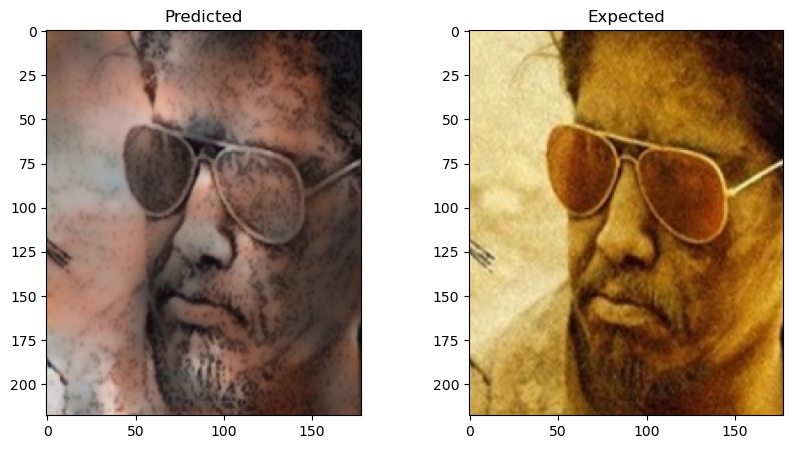

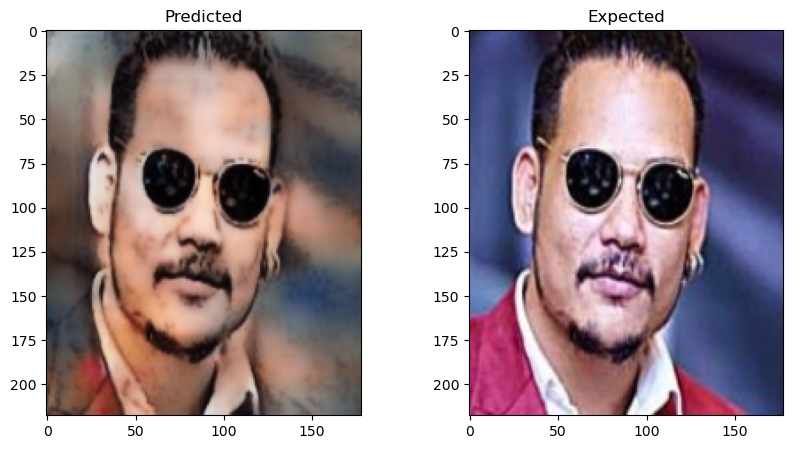

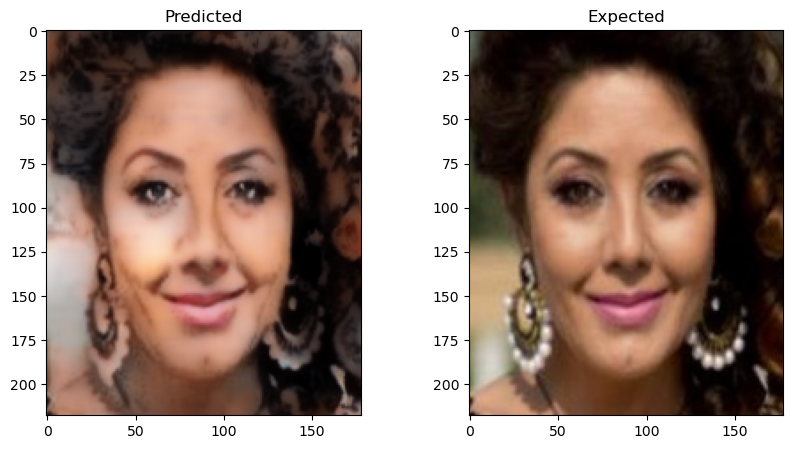

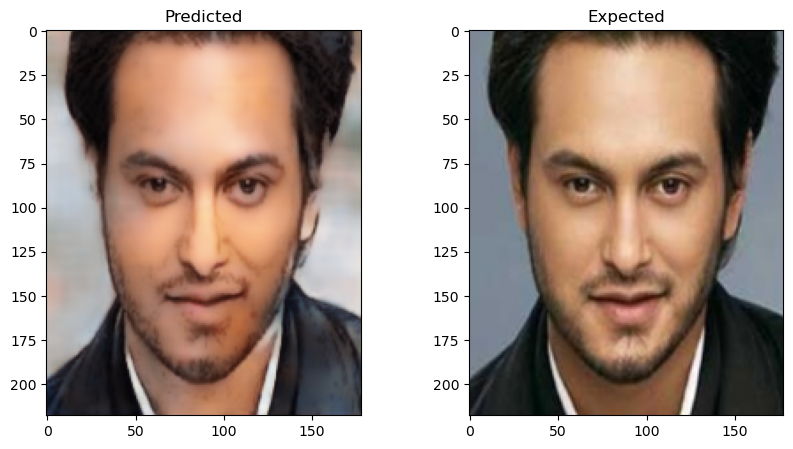

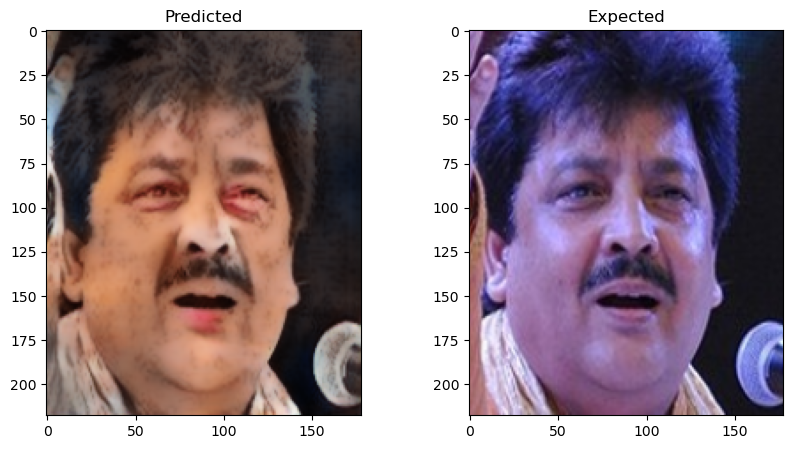

In [23]:
# Train the model using fit or fit_generator
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    verbose=1  # Set verbose to control logging output
)

# Visualization outside the loop for efficiency
val_x, val_y = val_gen.__getitem__(0)  # Get one batch for validation visualization
pred_y = model.predict(val_x)

# Plot predictions and ground truths
for i in range(min(len(pred_y), 5)):  # Show up to 5 examples
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pred_y[i])
    plt.title('Predicted')
    
    plt.subplot(1, 2, 2)
    plt.imshow(val_y[i])
    plt.title('Expected')
    
    plt.show()



In [24]:
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
checkpoint2 = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,save_weights_only =True,
    save_best_only=True, mode='auto', period=1)
history = model.fit_generator(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint2,checkpoint])
with open('history.pickle','wb') as file:
    pickle.dump(history.history,file)

Epoch 1/50


/tmp/ipykernel_7158/2985032710.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,epochs = epochs,validation_data = val_gen,callbacks=[checkpoint2,checkpoint])


162/162 [==============================] - ETA: 0s - loss: 0.0030 - dice_loss: 0.3879
Epoch 1: loss improved from inf to 0.00298, saving model to best_model.hdf5
162/162 [==============================] - 15s 89ms/step - loss: 0.0030 - dice_loss: 0.3879 - val_loss: 0.0229 - val_dice_loss: 0.3977
Epoch 2/50
162/162 [==============================] - ETA: 0s - loss: 0.0027 - dice_loss: 0.3873
Epoch 2: loss improved from 0.00298 to 0.00275, saving model to best_model.hdf5
162/162 [==============================] - 14s 87ms/step - loss: 0.0027 - dice_loss: 0.3873 - val_loss: 0.0227 - val_dice_loss: 0.4026
Epoch 3/50
162/162 [==============================] - ETA: 0s - loss: 0.0028 - dice_loss: 0.3874
Epoch 3: loss did not improve from 0.00275
162/162 [==============================] - 14s 86ms/step - loss: 0.0028 - dice_loss: 0.3874 - val_loss: 0.0227 - val_dice_loss: 0.4010
Epoch 4/50
162/162 [==============================] - ETA: 0s - loss: 0.0028 - dice_loss: 0.3874
Epoch 4: loss did n

# Testing the Model

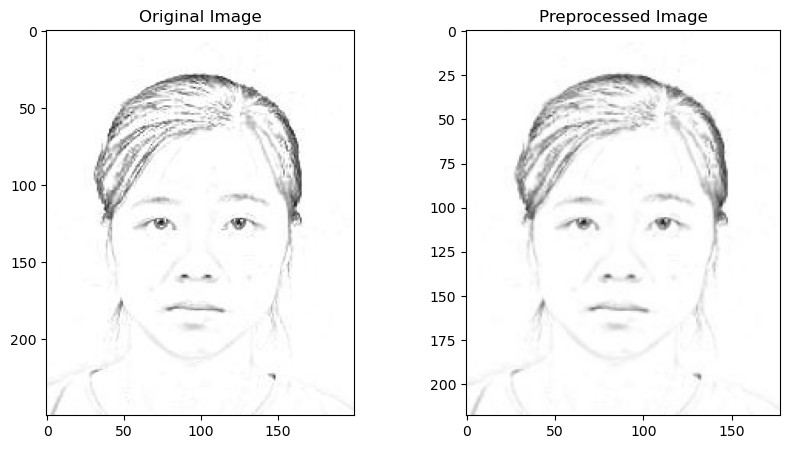

1/1 [==============================] - 4s 4s/step


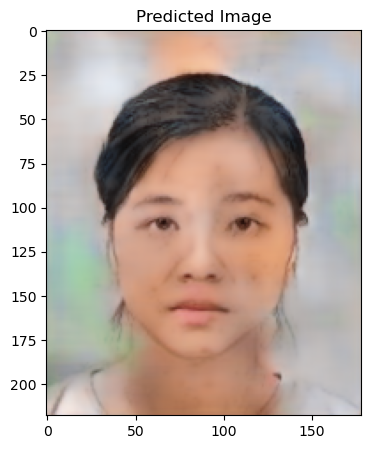

Max value in the image: 1.0


In [20]:

# Load model
model = load_model('model.h5', custom_objects={'dice_loss': dice_loss})

# Load weights instead of model
model.load_weights('best_model.hdf5')

# Load and preprocess image
img = cv2.imread('image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (178, 218))  # Resize to match model input size
img = img.astype(np.float32) / 255.0  # Normalize the image to range [0, 1]

# Visualize the original and preprocessed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread('image.jpg'), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('Preprocessed Image')

plt.show()

# Create a batch of 16 images (replicate the image 16 times)
img_batch = np.repeat(img[np.newaxis, ...], 16, axis=0)

# Predict with the model (reshape image for model input)
img_input = img.reshape(1, 218, 178, 3)
#y_pred = model.predict(img_input)
y_pred = model.predict(img_batch)

# Visualize the predicted image
plt.figure(figsize=(10, 5))
plt.imshow(y_pred[0])  # Display the predicted image
plt.title('Predicted Image')
plt.show()

# Optionally, save the predicted image
#matplotlib.image.imsave('predicted_image.png', y_pred[0])

# Check max value of the image for diagnostics
print(f"Max value in the image: {np.max(img.flatten())}")


1/1 [==============================] - 0s 390ms/step
Average SSIM: 0.3030


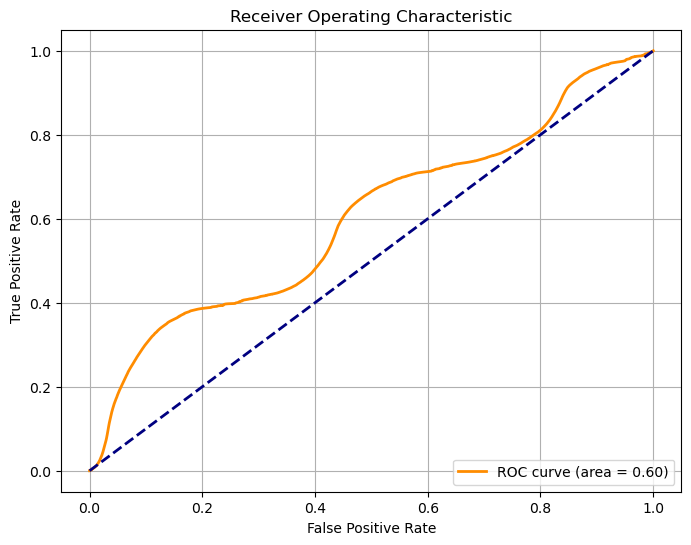

In [28]:

# Get the validation data
val_x, val_y = val_gen.__getitem__(0)
pred_y = model.predict(val_x)

# Determine an appropriate win_size 
win_size = 3  

# Calculate the data_range based on the images' min and max values
data_range = val_y.max() - val_y.min()

# Calculate SSIM for each image in the batch
ssim_scores = [
    ssim(val_y[i], pred_y[i], multichannel=True, win_size=win_size, data_range=data_range) for i in range(len(val_y))
]

# Print average SSIM score
avg_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {avg_ssim:.4f}")

# Flatten the images for ROC curve calculation
val_y_flat = val_y.flatten()
pred_y_flat = pred_y.flatten()

# Ensure binary labels for ROC curve
val_y_flat = np.round(val_y_flat)  
pred_y_flat = np.clip(pred_y_flat, 0, 1)  

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(val_y_flat, pred_y_flat)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)

# Save the plot as an image
plt.savefig('./accuracy/roc_curve.png')


plt.show()


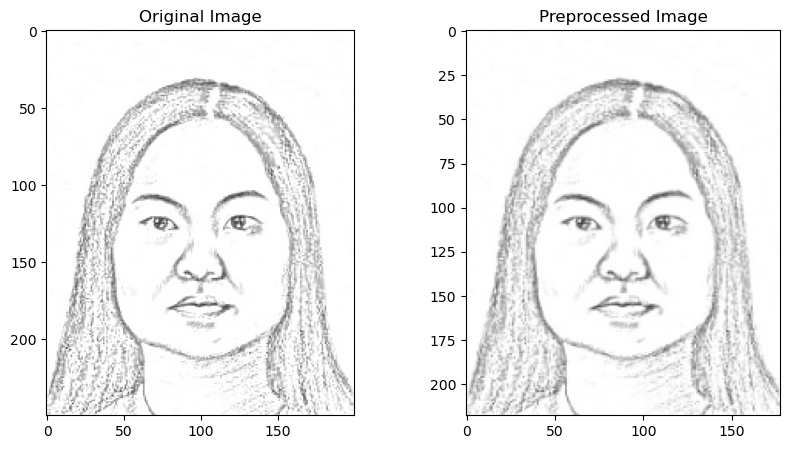

1/1 [==============================] - 0s 156ms/step


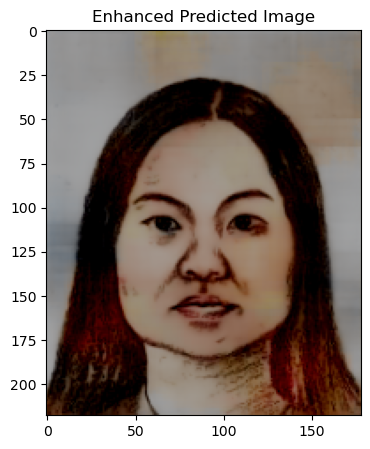

Max value in the enhanced image: 0.6372385025024414


In [24]:
model = load_model('model.h5', custom_objects={'dice_loss': dice_loss})

# Load and preprocess image
img = cv2.imread('ok.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img = cv2.resize(img, (178, 218))  # Resize to match model input size
img = img.astype(np.float32) / 255.0  # Normalize the image to range [0, 1]

# Visualize the original and preprocessed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread('ok.jpg'), cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('Preprocessed Image')

plt.show()

# Create a batch of 16 images (replicate the image 16 times)
img_batch = np.repeat(img[np.newaxis, ...], 16, axis=0)

# Predict with the model (use img_batch)
y_pred = model.predict(img_batch)

# Apply post-processing (darken the image and enhance)
y_pred = np.squeeze(y_pred)  # Remove batch dimension
y_pred = np.clip(y_pred, 0, 1)  # Ensure output is in range [0, 1]

# Darken the predicted image
darkened_img = np.clip(y_pred[0] * 0.5, 0, 1)  # Darken by 50%

# Enhance contrast (stretch pixel values)
enhanced_contrast_img = np.clip((darkened_img - 0.5) * 1.5 + 0.5, 0, 1)

# Boost saturation (increase color intensity)
enhanced_color_img = np.clip(enhanced_contrast_img * 1.3, 0, 1)  # Boost saturation by 30%

# Visualize the enhanced image
plt.figure(figsize=(10, 5))
plt.imshow(enhanced_color_img)
plt.title('Enhanced Predicted Image')
plt.show()

# Optionally, save the enhanced image
# matplotlib.image.imsave('enhanced_predicted_image.png', enhanced_color_img)

# Check max value of the enhanced image for diagnostics
print(f"Max value in the enhanced image: {np.max(enhanced_color_img.flatten())}")

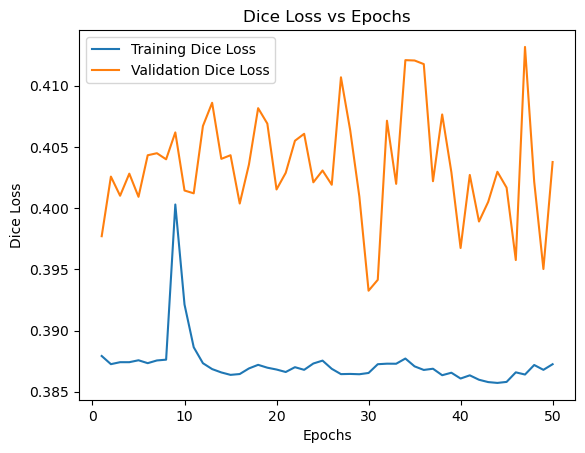

In [14]:
import pickle
import matplotlib.pyplot as plt

# Load the history from the pickle file
with open('history.pickle', 'rb') as file:
    history = pickle.load(file)

# Extract the Dice loss values
dice_loss = history.get('dice_loss', [])
val_dice_loss = history.get('val_dice_loss', [])

# Get the number of epochs (assuming the length of dice_loss matches the number of epochs)
epochs = range(1, len(dice_loss) + 1)

# Plot the Dice loss for training and validation
plt.plot(epochs, dice_loss, label='Training Dice Loss')
plt.plot(epochs, val_dice_loss, label='Validation Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.title('Dice Loss vs Epochs')
plt.legend()
plt.show()

2025-03-05 09:11:58.645086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-05 09:11:58.798844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-05 09:11:58.800167: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/15


2025-03-05 09:12:01.488536: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-03-05 09:12:05.017255: I external/local_xla/xla/service/service.cc:168] XLA service 0x7dd6a14bae70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-05 09:12:05.017284: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-03-05 09:12:05.028211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741145225.141032    6918 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 [==============================] - 27s 88ms/step - loss: 0.6365 - dice_loss: 0.5160 - iou: 0.3198 - val_loss: 0.6292 - val_dice_loss: 0.5011 - val_iou: 0.3325
Epoch 2/15
162/162 [==============================] - 14s 88ms/step - loss: 0.6166 - dice_loss: 0.4976 - iou: 0.3361 - val_loss: 0.5988 - val_dice_loss: 0.4616 - val_iou: 0.3686
Epoch 3/15
162/162 [==============================] - 14s 89ms/step - loss: 0.6015 - dice_loss: 0.4787 - iou: 0.3531 - val_loss: 0.5918 - val_dice_loss: 0.4593 - val_iou: 0.3708
Epoch 4/15
162/162 [==============================] - 15s 91ms/step - loss: 0.5906 - dice_loss: 0.4672 - iou: 0.3639 - val_loss: 0.5926 - val_dice_loss: 0.4765 - val_iou: 0.3548
Epoch 5/15
162/162 [==============================] - 14s 87ms/step - loss: 0.5883 - dice_loss: 0.4647 - iou: 0.3661 - val_loss: 0.5846 - val_dice_loss: 0.4355 - val_iou: 0.3936
Epoch 6/15
162/162 [==============================] - 15s 90ms/step - loss: 0.5829 - dice_loss: 0.4593 - iou: 0.3711 - va

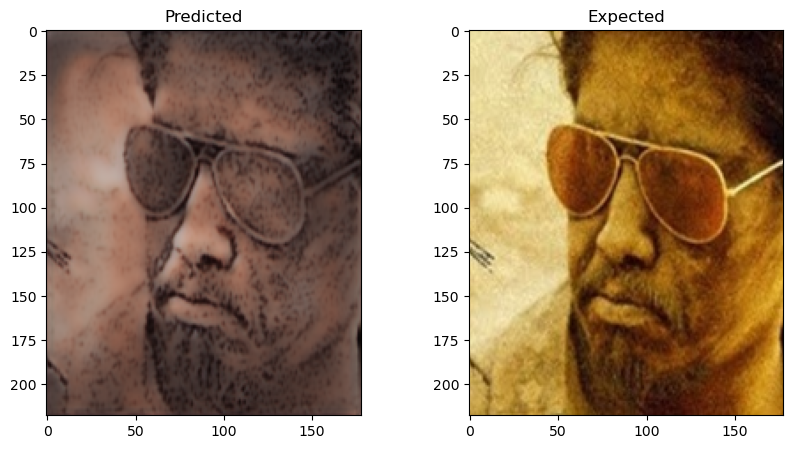

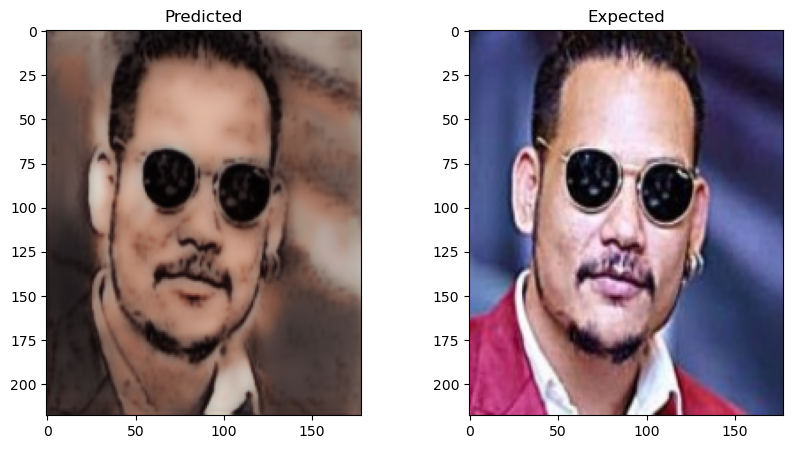

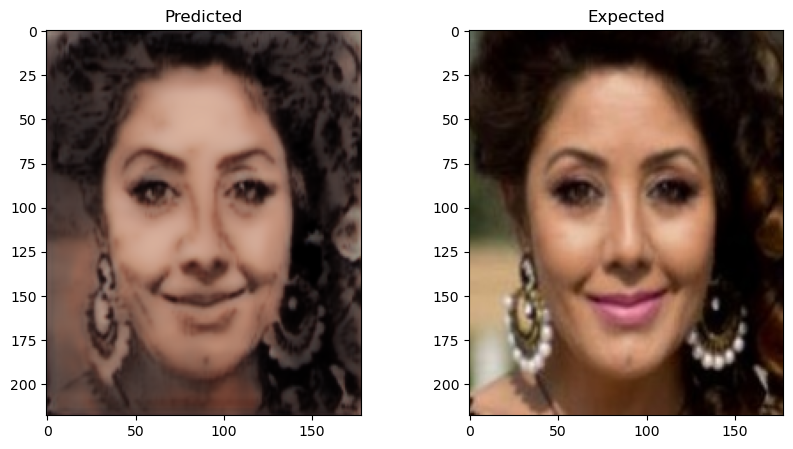

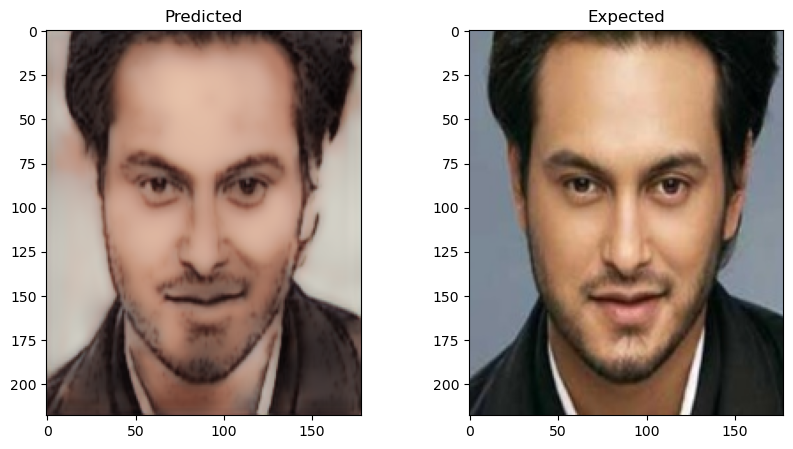

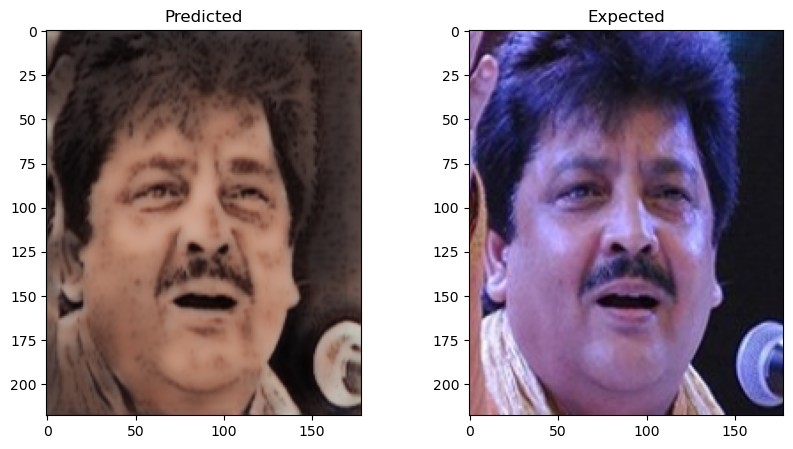

In [18]:
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

model = Unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_loss, iou])
# Train the model using fit or fit_generator
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    verbose=1  # Set verbose to control logging output
)

# Visualization outside the loop for efficiency
val_x, val_y = val_gen.__getitem__(0)  # Get one batch for validation visualization
pred_y = model.predict(val_x)

# Plot predictions and ground truths
for i in range(min(len(pred_y), 5)):  # Show up to 5 examples
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pred_y[i])
    plt.title('Predicted')
    
    plt.subplot(1, 2, 2)
    plt.imshow(val_y[i])
    plt.title('Expected')
    
    plt.show()

